<h1> Карташов Антон Валерьевич 
    <h2> Вариант 2
        <h3> Исправление. Задание №1

In [143]:
# импорт библиотек

import pandas as pd # мир пандам
import numpy as np

import scipy.stats as st # Статистика 

import matplotlib.pyplot as plt #Графики - сила
import seaborn as sb
import plotly.express as px
import plotly.graph_objects as go
import Boot_v2

%matplotlib inline

In [3]:
groups       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/58Us0DWOzuWAjg', sep = ';')
active_studs = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/prbgU-rZpiXVYg', sep = ';')
checks       = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84hTmELphW2sqQ', sep = ';')

<h2> Что имеем </h2> <br>
<b>groups.csv</b> - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) <br><br>
<b>active_studs.csv</b> - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. <br><br>
<b>checks.csv</b> - файл с информацией об оплатах пользователей в дни проведения эксперимента. <br><br>

In [4]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [8]:
checks = checks.rename(columns={'student_id':'id'})
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      541 non-null    int64  
 1   rev     541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [6]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [7]:
active_studs = active_studs.rename(columns={'student_id':'id'})
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [9]:
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Какие метрики используем: <br>
У нас есть определенный период исследования.
Мы знаем не так и много всего: количество пользователей в тестовой группе, количество активных пользователей (пользователи которые зашли на сайт) и сумму потраченную на товар:<br>
<br> (сократим количество метрик до двух)
<br><b>СR в покупку</b> (отношение числа пользователей, совершивших покупку, к количеству пользователей в группе);
<br><b>средний чек.


Для расчета первой метрики нам необходимо объединить таблицу с информацией о принадлежности пользователя к контрольной или экспериментальной группе и таблицу с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента (то есть активные пользователи). А после полученную таблицу объединяем с таблицей с информацией об оплатах пользователей в дни проведения эксперимента применяя, но применяя при этом объединение left. Это нам необходимо для того, чтобы определить, какие пользователи, участвующие в эксперименте, решились оплатить.

In [34]:
activ_user = active_studs.merge(groups, on='id').merge(checks,how='left', on = 'id')
activ_user

,id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN
...,...,...,...
8323,1794344,B,NaN
8324,296883,B,NaN
8325,3598448,B,NaN
8326,3610547,B,290.0


In [35]:
print('Количество оплативших:', activ_user['rev'].count())
print('Количество чеков:', checks['rev'].count())

Количество оплативших: 391
Количество чеков: 541


Тут у нас различие в количества чеков и количества юзеров, участвующих в эксперименте. Скорее в таблицу с чеками были добавлены юзеры, которые не участвовали в эксперементе.<br> 
Подготовка к анализу завершена. Для начала проверим СR в покупку для двух групп.

In [36]:
CR_A = round(activ_user[activ_user.grp == 'A'].rev.count()/activ_user[activ_user.grp == 'A'].grp.count()*100, 1)
CR_B = round(activ_user[activ_user.grp == 'B'].rev.count()/activ_user[activ_user.grp == 'B'].grp.count()*100, 1)
print('CR группы А =', CR_A,'%')
print('CR группы B =', CR_B,'%')

CR группы А = 5.1 %
CR группы B = 4.6 %


Как можно увидеть из резултатов в группе В конверия была ниже. Однако необходимо проверить значения на статистичесую значимость.
Вдруг коневерсии не значимо различаются друг от друга.<br>
Используем критерии Пирсона (критерий хи-квадрат), так как переменные у нас категориальные.
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть <br>

In [37]:
activ_user['ToF'] = activ_user.rev.isna()

In [38]:
activ_user

,id,grp,rev,ToF
0,581585,A,NaN,True
1,3276743,B,NaN,True
2,4238589,A,NaN,True
3,4475369,B,NaN,True
4,5481015,B,NaN,True
...,...,...,...,...
8323,1794344,B,NaN,True
8324,296883,B,NaN,True
8325,3598448,B,NaN,True
8326,3610547,B,290.0,False


In [47]:
_,p,_,_= st.chi2_contingency(pd.crosstab(activ_user.grp, activ_user.ToF))

print('p-value=', round(p,2))

if p <= 0.05:
    print('Отклоняем H0')
else:
    print('Принимаем H0')

p-value= 0.47
Принимаем H0


Из получившегося результата мы принимаем нулевую гепотезу и говорим что конверсии между двумя группами знамимых разлиций нет. 

Производим сравнение между средними чеками.

In [52]:
mean_table=activ_user.groupby('grp',as_index=False).rev.mean().round(2)
mean_table

,grp,rev
0,A,933.59
1,B,1255.83


In [57]:
print('Разница средних',abs(mean_table[mean_table.grp=='A'].rev[0]-mean_table[mean_table.grp=='B'].rev[1]).round(2))

Разница средних 322.24


Определим значимо ли это различие или нет.<br> Для начала проверим на нормальность распределения двух групп с помощью теста Шапиро-Уилка.

In [65]:
print(st.shapiro(activ_user[activ_user.grp=='A'].dropna().rev))
print(st.shapiro(activ_user[activ_user.grp=='B'].dropna().rev))

ShapiroResult(statistic=0.7353236079216003, pvalue=1.4986822893803264e-10)
ShapiroResult(statistic=0.8551987409591675, pvalue=1.756778758085431e-16)


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

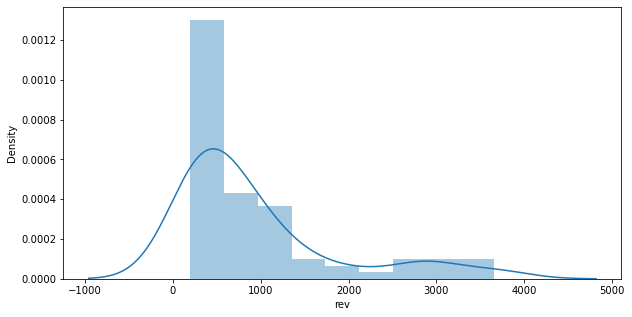

In [92]:
plt.figure(figsize=[10,5])

Aclear=activ_user[activ_user.grp=='A'].dropna()
sb.distplot(Aclear.rev)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rev', ylabel='Density'>

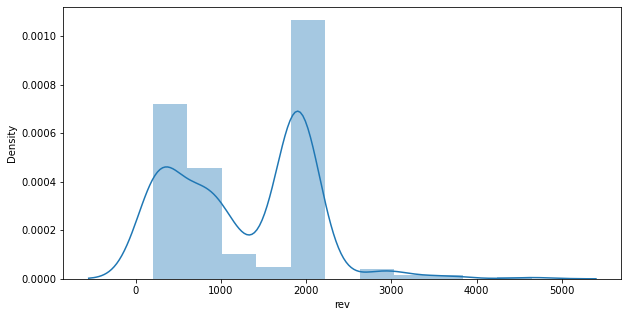

In [95]:
plt.figure(figsize=[10,5])

Bclear=activ_user[activ_user.grp=='B'].dropna()
sb.distplot(Bclear.rev)

Из результатов теста Шапиро-Уилка и графиков построенных выше, можно сказать что распределение значения чеков не нормальное в обеих группах.

Из выше сказанного => нам нужно применить критерий Манна-Уитни для сравнения средних двух групп.
- $H_0$: Среднии двух групп одинаковые
- $H_1$: Среднии двух групп различны <br>

In [90]:
_,p = st.mannwhitneyu(Aclear.rev,Bclear.rev)

print('p-value=', round(p,2))

if p <= 0.05:
    print('Отклоняем H0')
else:
    print('Принимаем H0')

p-value= 0.0
Отклоняем H0


Принимаем альтернативную гипотезу.

Таже для проверки равенства среднего в двух группах можно применить и бутстрап.

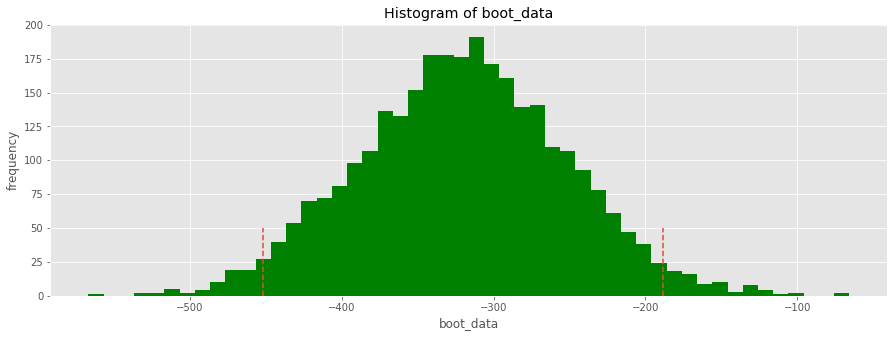

In [144]:
Return_p = Boot_v2.get_bootstrap(Aclear.rev, Bclear.rev)

In [145]:
if Return_p <= 0.05:
    print('Отклоняем H0')
else:
    print('Принимаем H0')

Отклоняем H0


При помощи бутстрапа мы также отклоняем нулевую гипотезу (равенство средних) и принимаем альтернативную гипотезу. 

Делаем вывод, что средний чек в тестовой группе значимо выше, чем в контрольной.

*Моя ошибка была в отклонении новой версии оплаты. <br>Проанализировав еще раз и посмотрев свежим взглядом на работу я меняю ответ на вопрос: Стоит ли запускать новую механику оплаты на всех пользователей? <br>
Мой новый ответ: ДА! Стоит все-таки принять новую технологию оплаты. Средний чек в группе B значимо отличается (в большую сторону) от среднего чека в Группе А.
